<a href="https://colab.research.google.com/github/seongcho1/mnetest/blob/main/eeg_motor_imagery_003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Decoding in time-frequency space using Common Spatial Patterns (CSP)
The time-frequency decomposition is estimated by iterating over raw data that has been band-passed at different frequencies. This is used to compute a covariance matrix over each epoch or a rolling time-window and extract the CSP filtered signals. A linear discriminant classifier is then applied to these signals.

https://mne.tools/stable/auto_examples/decoding/decoding_csp_timefreq.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

In [2]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 45.9 MB/s eta 0:00:00


In [3]:
from mne import Epochs, create_info, events_from_annotations
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import AverageTFR

Set parameters and read data

In [4]:
event_id = dict(hands=2, feet=3)  # motor imagery: hands vs feet
subject = 1
runs = [6, 10, 14]
raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f) for f in raw_fnames])

# Extract information from the raw file
sfreq = raw.info['sfreq']
events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
raw.pick_types(meg=False, eeg=True, stim=False, eog=False, exclude='bads')
raw.load_data()

# Assemble the classifier using scikit-learn pipeline
clf = make_pipeline(CSP(n_components=4, reg=None, log=True, norm_trace=False),
                    LinearDiscriminantAnalysis())
n_splits = 3  # for cross-validation, 5 is better, here we use 3 for speed
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Classification & time-frequency parameters
tmin, tmax = -.200, 2.000
n_cycles = 10.  # how many complete cycles: used to define window size
min_freq = 8.
max_freq = 20.
n_freqs = 6  # how many frequency bins to use

# Assemble list of frequency range tuples
freqs = np.linspace(min_freq, max_freq, n_freqs)  # assemble frequencies
freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples

# Infer window spacing from the max freq and number of cycles to avoid gaps
window_spacing = (n_cycles / np.max(freqs) / 2.)
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)

# Instantiate label encoder
le = LabelEncoder()

Using default location ~/mne_data for EEGBCI...
Creating ~/mne_data


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Reading 0 ... 59999  =      0.000 ...   374.994 secs...


Loop through frequencies, apply classifier and save scores

In [5]:
# init scores
freq_scores = np.zeros((n_freqs - 1,))

# Loop through each frequency range of interest
for freq, (fmin, fmax) in enumerate(freq_ranges):

    # Infer window size based on the frequency being used
    w_size = n_cycles / ((fmax + fmin) / 2.)  # in seconds

    # Apply band-pass filter to isolate the specified frequencies
    raw_filter = raw.copy().filter(fmin, fmax, fir_design='firwin',
                                   skip_by_annotation='edge')

    # Extract epochs from filtered data, padded by window size
    epochs = Epochs(raw_filter, events, event_id, tmin - w_size, tmax + w_size,
                    proj=False, baseline=None, preload=True)
    epochs.drop_bad()
    y = le.fit_transform(epochs.events[:, 2])

    X = epochs.get_data()

    # Save mean scores over folds for each frequency and time window
    freq_scores[freq] = np.mean(cross_val_score(
        estimator=clf, X=X, y=y, scoring='roc_auc', cv=cv), axis=0)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 10.40 Hz
- Upper transition bandwidth: 2.60 Hz (-6 dB cutoff frequency: 11.70 Hz)
- Filter length: 265 samples (1.656 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 701 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.1e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.3s finished


Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 629 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 64 dim * 7.6e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 64 dim * 7.6e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 64 dim * 7.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 581 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 8.9e-05 (2.2e-16 eps * 64 dim * 6.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.8e-05 (2.2e-16 eps * 64 dim * 6.9e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 549 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 7e-05 (2.2e-16 eps * 64 dim * 4.9e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.9e-05 (2.2e-16 eps * 64 dim * 5.6e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-05 (2.2e-16 eps * 64 dim * 5.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 6

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 523 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 6.2e-05 (2.2e-16 eps * 64 dim * 4.4e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-05 (2.2e-16 eps * 64 dim * 4.9e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e-05 (2.2e-16 eps * 64 dim * 4.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from

Plot frequency results

Text(0.5, 1.0, 'Frequency Decoding Scores')

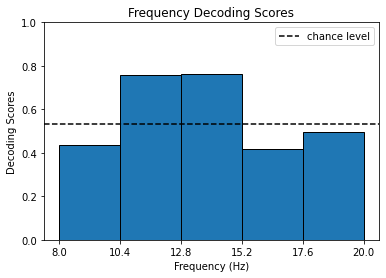

In [6]:
plt.bar(freqs[:-1], freq_scores, width=np.diff(freqs)[0],
        align='edge', edgecolor='black')
plt.xticks(freqs)
plt.ylim([0, 1])
plt.axhline(len(epochs['feet']) / len(epochs), color='k', linestyle='--',
            label='chance level')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Decoding Scores')
plt.title('Frequency Decoding Scores')

Loop through frequencies and time, apply classifier and save scores

In [7]:
# init scores
tf_scores = np.zeros((n_freqs - 1, n_windows))

# Loop through each frequency range of interest
for freq, (fmin, fmax) in enumerate(freq_ranges):

    # Infer window size based on the frequency being used
    w_size = n_cycles / ((fmax + fmin) / 2.)  # in seconds

    # Apply band-pass filter to isolate the specified frequencies
    raw_filter = raw.copy().filter(fmin, fmax, fir_design='firwin',
                                   skip_by_annotation='edge')

    # Extract epochs from filtered data, padded by window size
    epochs = Epochs(raw_filter, events, event_id, tmin - w_size, tmax + w_size,
                    proj=False, baseline=None, preload=True)
    epochs.drop_bad()
    y = le.fit_transform(epochs.events[:, 2])

    # Roll covariance, csp and lda over time
    for t, w_time in enumerate(centered_w_times):

        # Center the min and max of the window
        w_tmin = w_time - w_size / 2.
        w_tmax = w_time + w_size / 2.

        # Crop data into time-window of interest
        X = epochs.copy().crop(w_tmin, w_tmax).get_data()

        # Save mean scores over folds for each frequency and time window
        tf_scores[freq, t] = np.mean(cross_val_score(
            estimator=clf, X=X, y=y, scoring='roc_auc', cv=cv), axis=0)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 10.40 Hz
- Upper transition bandwidth: 2.60 Hz (-6 dB cutoff frequency: 11.70 Hz)
- Filter length: 265 samples (1.656 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 701 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 6.2e-05 (2.2e-16 eps * 64 dim * 4.4e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.4e-05 (2.2e-16 eps * 64 dim * 4.5e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.1e-05 (2.2e-16 eps * 64 dim * 4.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 629 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 5.5e-05 (2.2e-16 eps * 64 dim * 3.9e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.9e-05 (2.2e-16 eps * 64 dim * 3.5e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.4e-05 (2.2e-16 eps * 64 dim * 3.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 581 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 4.1e-05 (2.2e-16 eps * 64 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.2e-05 (2.2e-16 eps * 64 dim * 3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.2e-05 (2.2e-16 eps * 64 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 6

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 549 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 3e-05 (2.2e-16 eps * 64 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 64 dim * 2.4e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.9e-05 (2.2e-16 eps * 64 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 6

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 523 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 2.4e-05 (2.2e-16 eps * 64 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 64 dim * 2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.5e-05 (2.2e-16 eps * 64 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 6

Plot time-frequency results

No baseline correction applied


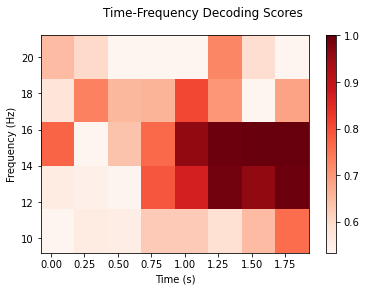

[<Figure size 432x288 with 2 Axes>]

In [8]:
# Set up time frequency object
av_tfr = AverageTFR(create_info(['freq'], sfreq), tf_scores[np.newaxis, :],
                    centered_w_times, freqs[1:], 1)

chance = np.mean(y)  # set chance level to white in the plot
av_tfr.plot([0], vmin=chance, title="Time-Frequency Decoding Scores",
            cmap=plt.cm.Reds)